## From our current EDA file - no need to add

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats as stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import statsmodels.api as sm

def drop_outliers(df, col):
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    iqr = q3 - q1

    lower_lim = q1 - 1.5 * iqr
    upper_lim = q3 + 1.5 * iqr

    df = df.loc[ (df[col] >= lower_lim) & (df[col] <= upper_lim) ].reset_index(drop=True)
    return df

def scale_numberical_cols(df, cols_to_scale):
    df = df.copy()
    features = cols_to_scale
    autoscaler = StandardScaler()
    df[features] = autoscaler.fit_transform(df[features])
    return df

## Add in below

### EDA - Baseline OLS Model - v2 
#### Trying a new baseline model to get better model statistics.
- Just sqrt_foot living vs target of price

In [2]:
df = pd.read_csv('data/kc_house_data.csv')

x = sm.add_constant(df[['sqft_living']])
y = df['price']
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                 1.773e+04
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:09:50   Log-Likelihood:            -4.4912e+05
No. Observations:               30155   AIC:                         8.982e+05
Df Residuals:                   30153   BIC:                         8.983e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.443e+04   9782.728     -7.609      0.000   -9.36e+04   -5.53e+04
sqft_living   560.0050      4.206    133.160      0.000     551.762     568.248
==============================================================================
Omnibus:                    43429.367   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         47159181.471
Skew:                           8.188   Prob(JB):                         0.00
Kurtosis:                     196.042   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Trying to see if address helps us**

In [3]:
df['address'][0]

'2102 Southeast 21st Court, Renton, Washington 98055, United States'

**Add in some new mapper functions to parse out some df columns**

In [4]:
# New Mapper functions for changing df values
def mapping_addressStreet(row):
    row = row.split(",")[0]
    row = row.split(" ")
    row = " ".join(row[1:])
    return row 

def mapping_addressCity(row):
    row = row.split(",")[-3].strip()
    return row 
    
def mapping_hasX(row):
    if row == 0:
        row = 0
    else:
        row = 1
    return row

In [5]:
# lets start from new baseline and play around with some new ideas on features 

df = drop_outliers(df, 'sqft_living').reset_index(drop=True)
df = drop_outliers(df, 'price').reset_index(drop=True)
df = df.dropna().reset_index(drop=True)


df['date_year'] = df['date'].apply(pd.to_datetime)
df['date_year'] = df['date_year'].dt.year
df['date_year']
df['age_when_sold'] = df['date_year'] - df['yr_built']
df['age_when_sold']

# Continuous numbers
#df['sqft_living']
df['sqft_lot_less_living'] = df['sqft_lot'] - (df['sqft_living']/df['floors'])

# Nominal categories
df['zipcode'] = df.address.str[-20:-15]
df['has_garage'] = df['sqft_garage'].map(mapping_hasX)
df['has_patio'] = df['sqft_patio'].map(mapping_hasX)
df['has_basement'] = df['sqft_basement'].map(mapping_hasX)
df['waterfront']
df['street'] = df['address'].map(mapping_addressStreet)
df['city'] = df['address'].map(mapping_addressCity)

# Ordinal categories
df['grade']

# Scale the continous number features
df = scale_numberical_cols(df, ['sqft_living', 'age_when_sold', 'sqft_lot_less_living'])

# Baseline
x = sm.add_constant(df[['sqft_living']])
y = df['price']
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                 1.176e+04
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:09:54   Log-Likelihood:            -3.9264e+05
No. Observations:               27692   AIC:                         7.853e+05
Df Residuals:                   27690   BIC:                         7.853e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         9.26e+05   2091.210    442.802      0.000    9.22e+05     9.3e+05
sqft_living  2.268e+05   2091.210    108.441      0.000    2.23e+05    2.31e+05
==============================================================================
Omnibus:                     1234.082   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1454.890
Skew:                           0.505   Prob(JB):                         0.00
Kurtosis:                       3.493   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Check out the new features**

In [6]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,long,date_year,age_when_sold,sqft_lot_less_living,zipcode,has_garage,has_patio,has_basement,street,city
0,7399300360,5/24/2022,675000.0,4,1.0,-1.031441,7140,1.0,NO,NO,...,-122.19052,2022,0.184379,-0.147410,98055,0,1,0,Southeast 21st Court,Renton
1,8910500230,12/13/2021,920000.0,5,2.5,1.074642,6703,1.0,NO,NO,...,-122.35591,2021,0.748342,-0.186239,98133,0,1,1,Greenwood Avenue North,Seattle
2,1180000275,9/29/2021,311000.0,6,2.0,1.220346,6156,1.0,NO,NO,...,-122.22520,2021,0.560354,-0.198824,98178,0,0,1,South 113th Street,Seattle
3,1604601802,12/14/2021,775000.0,3,3.0,0.266648,1400,2.0,NO,NO,...,-122.29020,2021,-1.131536,-0.255448,98118,1,1,1,Letitia Avenue South,Seattle
4,8562780790,8/24/2021,592500.0,2,2.0,-1.110916,758,2.0,NO,NO,...,-122.07188,2021,-1.194199,-0.257785,98027,1,1,1,Northwest Talus Drive,Issaquah


**Make sure target is normalized after scaling**

<AxesSubplot:xlabel='price', ylabel='Count'>

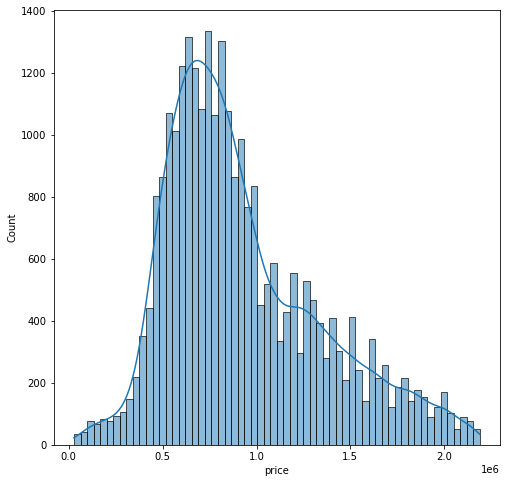

In [7]:
fig, ax = plt.subplots(figsize=(8,8))
sns.histplot(df.price, kde=True)

**Add in new feature 'sqft_lot_less_living', see what it does**

In [8]:
x = sm.add_constant(df[['sqft_living','sqft_lot_less_living']])    
y = df['price']
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     5886.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:09:54   Log-Likelihood:            -3.9264e+05
No. Observations:               27692   AIC:                         7.853e+05
Df Residuals:                   27689   BIC:                         7.853e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  9.26e+05   2090.883    442.871      0.000    9.22e+05     9.3e+05
sqft_living           2.262e+05   2098.380    107.808      0.000    2.22e+05     2.3e+05
sqft_lot_less_living  6524.0770   2098.380      3.109      0.002    2411.147    1.06e+04
==============================================================================
Omnibus:                     1223.273   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1439.380
Skew:                           0.503   Prob(JB):                         0.00
Kurtosis:                       3.487   Cond. No.                         1.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**sqft lot helps jarque bera a tiny amount**

**Layer in 'age_when_sold' feature**

In [13]:
x = sm.add_constant(df[['sqft_living','sqft_lot_less_living', 'age_when_sold']])    
y = df['price']
model = sm.OLS(y, x).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     4116.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:12:24   Log-Likelihood:            -3.9244e+05
No. Observations:               27692   AIC:                         7.849e+05
Df Residuals:                   27688   BIC:                         7.849e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  9.26e+05   2075.816    446.085      0.000    9.22e+05     9.3e+05
sqft_living           2.392e+05   2181.541    109.666      0.000    2.35e+05    2.44e+05
sqft_lot_less_living  4952.9766   2084.724      2.376      0.018     866.815    9039.138
age_when_sold         4.372e+04   2173.872     20.110      0.000    3.95e+04     4.8e+04
==============================================================================
Omnibus:                     1083.525   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1279.411
Skew:                           0.460   Prob(JB):                    1.51e-278
Kurtosis:                       3.514   Cond. No.                         1.37
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**age_when_sold brings down Jarque-bera and omnibus**

**Try out new nominal categorical features using one hot encoder**

In [14]:
x = df[['sqft_living', 'sqft_lot_less_living']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']

ohe = OneHotEncoder(drop='first')
ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),columns=ohe.get_feature_names())
X_cat = pd.concat([x,ohe_all], axis=1)
scaled_oheall_model = sm.OLS(y, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     143.0
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:12:54   Log-Likelihood:            -3.8447e+05
No. Observations:               27692   AIC:                         7.695e+05
Df Residuals:                   27390   BIC:                         7.720e+05
Df Model:                         301                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       5.364e+05   3.71e+04     14.452      0.000    4.64e+05    6.09e+05
sqft_living                  2.13e+05   1809.520    117.684      0.000    2.09e+05    2.16e+05
sqft_lot_less_living        2.452e+04   1650.483     14.857      0.000    2.13e+04    2.78e+04
x0_Allston                  3.806e+05   1.22e+05      3.115      0.002    1.41e+05     6.2e+05
x0_Altoona                  4.301e+05   1.88e+05      2.290      0.022    6.19e+04    7.98e+05
x0_Ames Lake                4.799e+05   2.63e+05      1.824      0.068   -3.58e+04    9.96e+05
x0_Anchorage                4.254e+05   1.55e+05      2.747      0.006    1.22e+05    7.29e+05
x0_Ardoch                   3.335e+05   1.35e+05      2.463      0.014    6.82e+04    5.99e+05
x0_Arlington                9.787e+05   1.55e+05      6.319      0.000    6.75e+05    1.28e+06
x0_Asbury Park              4.414e+05   9.93e+04      4.447      0.000    2.47e+05    6.36e+05
x0_Auburn                   2.683e+04   3.75e+04      0.716      0.474   -4.66e+04       1e+05
x0_Austin                  -1.224e+05   2.63e+05     -0.465      0.642   -6.38e+05    3.93e+05
x0_Baldwin                  5.691e+05   1.05e+05      5.412      0.000    3.63e+05    7.75e+05
x0_Baring                   7.778e+04   1.13e+05      0.691      0.490   -1.43e+05    2.98e+05
x0_Bay Shore                9.394e+05   1.88e+05      5.001      0.000    5.71e+05    1.31e+06
x0_Beach Haven              5.261e+05   7.88e+04      6.674      0.000    3.72e+05    6.81e+05
x0_Beaux Arts               1.263e+06   1.13e+05     11.221      0.000    1.04e+06    1.48e+06
x0_Beaver Falls             3.215e+05   2.63e+05      1.222      0.222   -1.94e+05    8.37e+05
x0_Beaverton                1.142e+06   2.63e+05      4.342      0.000    6.26e+05    1.66e+06
x0_Bellevue                 7.597e+05   3.77e+04     20.131      0.000    6.86e+05    8.34e+05
x0_Berger                   6.883e+05   1.88e+05      3.664      0.000     3.2e+05    1.06e+06
x0_Billings                 5.597e+05   1.88e+05      2.979      0.003    1.91e+05    9.28e+05
x0_Bismarck                 4.006e+05   8.67e+04      4.618      0.000    2.31e+05    5.71e+05
x0_Black Diamond            5.554e+04   4.02e+04      1.383      0.167   -2.32e+04    1.34e+05
x0_Boise                    9.003e+05   2.63e+05      3.423      0.001    3.85e+05    1.42e+06
x0_Bothell                   4.95e+05   4.04e+04     12.252      0.000    4.16e+05    5.74e+05
x0_Bradenton                6.298e+05   2.63e+05      2.394      0.017    1.14e+05    1.15e+06
x0_Brentwood                5.503e+05   1.55e+05      3.554      0.000    2.47e+05    8.54e+05
x0_Brooksville              7.449e+05   2.63e+05      2.831      0.005    2.29e+05    1.26e+06
x0_Burien                    1.81e+05   3.8

**Found that City is the kicker that kicks us up the most (to .6+ r squared) while not making JB and Condo astronomicalThis looks like the best option so far.**  

**Try layering in a Ordinal Categorical variable (Grade)**

In [11]:
# ordinally encoding grade
grade_df = df[['grade']]
grade_cats = [['2 Substandard',
               '3 Poor',
               '4 Low',
               '5 Fair',
               '6 Low Average',
               '7 Average',
               '8 Good',
               '9 Better',
               '10 Very Good',
               '11 Excellent',
               '12 Luxury',
               '13 Mansion']]
ords_grade = OrdinalEncoder(categories=grade_cats)
ords_grade.fit(grade_df)
ords_grade.transform(grade_df)
grades_encoded = pd.DataFrame(ords_grade.transform(grade_df))


x=df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']
ohe = OneHotEncoder(drop='first')

ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,grades_encoded], axis=1)
scaled_oheall_model = sm.OLS(y, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     163.0
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:09:58   Log-Likelihood:            -3.8327e+05
No. Observations:               27692   AIC:                         7.671e+05
Df Residuals:                   27388   BIC:                         7.696e+05
Df Model:                         303                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       4667.9822   3.72e+04      0.125      0.900   -6.83e+04    7.76e+04
sqft_living                 1.623e+05   2136.494     75.980      0.000    1.58e+05    1.67e+05
sqft_lot_less_living        2.196e+04   1582.745     13.875      0.000    1.89e+04    2.51e+04
age_when_sold               7.134e+04   2121.279     33.632      0.000    6.72e+04    7.55e+04
x0_Allston                  3.162e+05   1.17e+05      2.699      0.007    8.66e+04    5.46e+05
x0_Altoona                  3.281e+05    1.8e+05      1.823      0.068   -2.47e+04    6.81e+05
x0_Ames Lake                4.626e+05   2.52e+05      1.836      0.066   -3.12e+04    9.57e+05
x0_Anchorage                 3.47e+05   1.48e+05      2.338      0.019    5.61e+04    6.38e+05
x0_Ardoch                   3.189e+05    1.3e+05      2.459      0.014    6.47e+04    5.73e+05
x0_Arlington                9.121e+05   1.48e+05      6.148      0.000    6.21e+05     1.2e+06
x0_Asbury Park              3.945e+05   9.51e+04      4.146      0.000    2.08e+05    5.81e+05
x0_Auburn                  -2.522e+04   3.59e+04     -0.702      0.483   -9.56e+04    4.52e+04
x0_Austin                   3.192e+04   2.52e+05      0.127      0.899   -4.62e+05    5.26e+05
x0_Baldwin                  4.421e+05   1.01e+05      4.383      0.000    2.44e+05     6.4e+05
x0_Baring                   6.893e+04   1.08e+05      0.639      0.523   -1.42e+05     2.8e+05
x0_Bay Shore                 8.19e+05    1.8e+05      4.551      0.000    4.66e+05    1.17e+06
x0_Beach Haven              4.498e+05   7.56e+04      5.947      0.000    3.02e+05    5.98e+05
x0_Beaux Arts                1.16e+06   1.08e+05     10.763      0.000    9.49e+05    1.37e+06
x0_Beaver Falls             2.349e+05   2.52e+05      0.932      0.351   -2.59e+05    7.29e+05
x0_Beaverton                9.636e+05   2.52e+05      3.825      0.000     4.7e+05    1.46e+06
x0_Bellevue                 6.459e+05   3.62e+04     17.836      0.000    5.75e+05    7.17e+05
x0_Berger                   5.057e+05    1.8e+05      2.810      0.005    1.53e+05    8.58e+05
x0_Billings                 4.683e+05    1.8e+05      2.603      0.009    1.16e+05    8.21e+05
x0_Bismarck                 3.412e+05   8.32e+04      4.104      0.000    1.78e+05    5.04e+05
x0_Black Diamond            4.047e+04   3.85e+04      1.052      0.293    -3.5e+04    1.16e+05
x0_Boise                    8.225e+05   2.52e+05      3.265      0.001    3.29e+05    1.32e+06
x0_Bothell                  4.222e+05   3.87e+04     10.902      0.000    3.46e+05    4.98e+05
x0_Bradenton                 4.45e+05   2.52e+05      1.766      0.077    -4.9e+04    9.39e+05
x0_Brentwood                4.242e+05   1.48e+05      2.859      0.004    1.33e+05    7.15e+05
x0_Brooksville              5.603e+05   2.5

**This skyrockets our JB and our cond. no.  No go for Grade.**  

**Now try Condition**

In [12]:
# ordinally encoding condition
cond_df = df[['condition']]
cond_cats = [['Poor',
              'Fair',
              'Average',
              'Good',
              'Very Good']]
ords_cond = OrdinalEncoder(categories=cond_cats)
ords_cond.fit(cond_df)
ords_cond.transform(cond_df)
cond_encoded = pd.DataFrame(ords_cond.transform(cond_df))
cond_encoded

x=df[['sqft_living', 'sqft_lot_less_living', 'age_when_sold']]
ohe_cols = ['city','waterfront', 'has_basement', 'has_garage', 'has_patio']
ohe = OneHotEncoder(drop='first')

ohe.fit(df[ohe_cols])
ohe_all = pd.DataFrame(ohe.transform(df[ohe_cols]).todense(),
                            columns=ohe.get_feature_names())

X_cat = pd.concat([x,ohe_all,cond_encoded], axis=1)
scaled_oheall_model = sm.OLS(y, sm.add_constant(X_cat)).fit()
scaled_oheall_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     146.9
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        22:09:59   Log-Likelihood:            -3.8418e+05
No. Observations:               27692   AIC:                         7.690e+05
Df Residuals:                   27388   BIC:                         7.715e+05
Df Model:                         303                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       4.228e+05   3.71e+04     11.386      0.000     3.5e+05    4.96e+05
sqft_living                 2.186e+05   1827.177    119.611      0.000    2.15e+05    2.22e+05
sqft_lot_less_living        2.397e+04   1635.836     14.653      0.000    2.08e+04    2.72e+04
age_when_sold               2.043e+04   2110.867      9.677      0.000    1.63e+04    2.46e+04
x0_Allston                  4.417e+05   1.21e+05      3.650      0.000    2.04e+05    6.79e+05
x0_Altoona                  4.972e+05   1.86e+05      2.674      0.008    1.33e+05    8.62e+05
x0_Ames Lake                4.985e+05    2.6e+05      1.914      0.056   -1.19e+04    1.01e+06
x0_Anchorage                4.909e+05   1.53e+05      3.202      0.001     1.9e+05    7.91e+05
x0_Ardoch                   3.744e+05   1.34e+05      2.794      0.005    1.12e+05    6.37e+05
x0_Arlington                1.011e+06   1.53e+05      6.598      0.000    7.11e+05    1.31e+06
x0_Asbury Park              4.983e+05   9.83e+04      5.070      0.000    3.06e+05    6.91e+05
x0_Auburn                   1.684e+04   3.71e+04      0.454      0.650   -5.59e+04    8.96e+04
x0_Austin                  -1.098e+05    2.6e+05     -0.422      0.673    -6.2e+05    4.01e+05
x0_Baldwin                  6.346e+05   1.04e+05      6.093      0.000     4.3e+05    8.39e+05
x0_Baring                   9.977e+04   1.11e+05      0.896      0.370   -1.19e+05    3.18e+05
x0_Bay Shore                9.824e+05   1.86e+05      5.284      0.000    6.18e+05    1.35e+06
x0_Beach Haven              5.847e+05   7.81e+04      7.487      0.000    4.32e+05    7.38e+05
x0_Beaux Arts               1.257e+06   1.11e+05     11.284      0.000    1.04e+06    1.48e+06
x0_Beaver Falls             3.662e+05    2.6e+05      1.406      0.160   -1.44e+05    8.77e+05
x0_Beaverton                 1.14e+06    2.6e+05      4.380      0.000     6.3e+05    1.65e+06
x0_Bellevue                 7.391e+05   3.74e+04     19.783      0.000    6.66e+05    8.12e+05
x0_Berger                     7.4e+05   1.86e+05      3.980      0.000    3.76e+05     1.1e+06
x0_Billings                 6.009e+05   1.86e+05      3.232      0.001    2.36e+05    9.65e+05
x0_Bismarck                 4.455e+05   8.59e+04      5.186      0.000    2.77e+05    6.14e+05
x0_Black Diamond            6.411e+04   3.98e+04      1.612      0.107   -1.38e+04    1.42e+05
x0_Boise                    9.517e+05    2.6e+05      3.655      0.000    4.41e+05    1.46e+06
x0_Bothell                  4.928e+05      4e+04     12.324      0.000    4.14e+05    5.71e+05
x0_Bradenton                6.959e+05    2.6e+05      2.673      0.008    1.86e+05    1.21e+06
x0_Brentwood                6.103e+05   1.53e+05      3.982      0.000     3.1e+05    9.11e+05
x0_Brooksville              8.172e+05    2.

**This gives us a slightly better r squared (.619 vs .611 - our prior best), but it also doubles our condition and increases our JB by 1000.**  

**Need to discuss these and choose the best**